In [1]:
symbol = "NVDA"
shift = 5
confidence = .5

In [2]:
import yfinance as yf
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.ensemble import HistGradientBoostingClassifier
from ta.trend import ema_indicator

In [3]:
stock = yf.Ticker(symbol)
#vix = yf.Ticker('^VIX').history('max')
#vix.index = pd.to_datetime(vix.index)
stock = stock.history(period = "max")
stock.index = pd.to_datetime(stock.index)
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.401320,0.447901,0.355933,0.376237,271468800,0.0,0.0
1999-01-25 00:00:00-05:00,0.406097,0.420430,0.376237,0.415653,51048000,0.0,0.0
1999-01-26 00:00:00-05:00,0.420430,0.428791,0.377431,0.383404,34320000,0.0,0.0
1999-01-27 00:00:00-05:00,0.384598,0.394154,0.363098,0.382210,24436800,0.0,0.0
1999-01-28 00:00:00-05:00,0.382210,0.384598,0.378626,0.381015,22752000,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-23 00:00:00-04:00,807.690002,827.690002,802.640015,824.229980,43855900,0.0,0.0
2024-04-24 00:00:00-04:00,839.500000,840.820007,791.830017,796.770020,51220800,0.0,0.0
2024-04-25 00:00:00-04:00,788.679993,833.229980,782.229980,826.320007,42464100,0.0,0.0


<Axes: xlabel='Date'>

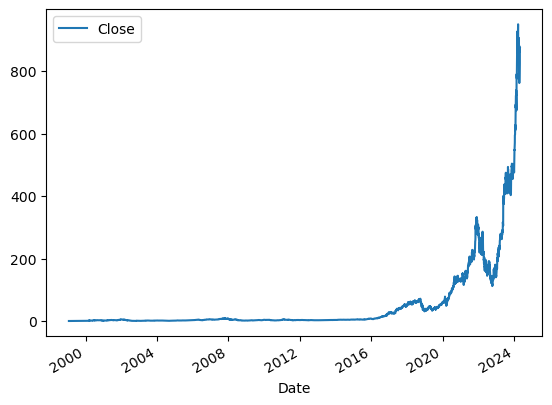

In [4]:
stock.plot.line(y="Close", use_index=True)

In [5]:
del stock['Dividends']
del stock['Stock Splits']

In [6]:
stock["Tomorrow"] = stock["Close"].shift(-shift)
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)

stock = stock.loc["2000-01-01":].copy()

#vix = vix.loc["2000-01-01":].copy()#.iloc[:-1]
#vix['Close'] = vix['Close'] * 3
#IV = pd.Series(vix['Close'])
#stock['IV'] = IV.tolist()
stock

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2000-01-03 00:00:00-05:00,0.902969,0.910136,0.843249,0.894608,30091200,0.826528,0
2000-01-04 00:00:00-05:00,0.879081,0.881470,0.826528,0.870721,30048000,0.793084,0
2000-01-05 00:00:00-05:00,0.845638,0.859971,0.830111,0.842055,18835200,0.772779,0
2000-01-06 00:00:00-05:00,0.842055,0.842055,0.754863,0.787112,12048000,0.805028,1
2000-01-07 00:00:00-05:00,0.783529,0.808611,0.771585,0.800251,7118400,0.839666,1
...,...,...,...,...,...,...,...
2024-04-23 00:00:00-04:00,807.690002,827.690002,802.640015,824.229980,43855900,NaN,0
2024-04-24 00:00:00-04:00,839.500000,840.820007,791.830017,796.770020,51220800,NaN,0
2024-04-25 00:00:00-04:00,788.679993,833.229980,782.229980,826.320007,42464100,NaN,0


In [7]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [8]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= confidence] = 1
    preds[preds < confidence] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [9]:
def predict_recent(test, predictors, model):
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= confidence] = 1
    preds[preds < confidence] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [10]:
import warnings
warnings.filterwarnings("ignore")

horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = stock.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    stock[ratio_column] = stock["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]
    

stock['EMA_5'] = ema_indicator(stock.Close, window = 5).tolist()
stock['EMA_2'] = ema_indicator(stock.Close, window = 2).tolist()
stock['EMA_10'] = ema_indicator(stock.Close, window = 10).tolist()
stock['EMA_25'] = ema_indicator(stock.Close, window = 25).tolist()
new_predictors += ['EMA_5', 'EMA_2', 'EMA_10', 'EMA_25']

from ta.volatility import bollinger_hband, bollinger_lband, bollinger_mavg

stock['Bollinger High'] = bollinger_hband(stock.Close, window = 250).tolist()
stock['Bollinger Mid'] = bollinger_mavg(stock.Close, window = 250).tolist()
stock['Bollinger Low'] = bollinger_lband(stock.Close, window = 250).tolist()
new_predictors += ['Bollinger High', 'Bollinger Mid', 'Bollinger Low']

from ta.momentum import rsi

stock['RSI_1'] = rsi(stock.Close, window = 1).tolist()
stock['RSI_5'] = rsi(stock.Close, window = 5).tolist()
stock['RSI_25'] = rsi(stock.Close, window = 25).tolist()
new_predictors += ['RSI_1', 'RSI_5', 'RSI_25']

from ta.volume import force_index

stock['FI_1'] = force_index(stock.Close, stock.Volume, window = 1).tolist()
stock['FI_5'] = force_index(stock.Close, stock.Volume, window = 5).tolist()
stock['FI_25'] = force_index(stock.Close, stock.Volume, window = 25).tolist()
new_predictors += ['FI_1', 'FI_5', 'FI_25']

#new_predictors += ['IV']

new_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000',
 'EMA_5',
 'EMA_2',
 'EMA_10',
 'EMA_25',
 'Bollinger High',
 'Bollinger Mid',
 'Bollinger Low',
 'RSI_1',
 'RSI_5',
 'RSI_25',
 'FI_1',
 'FI_5',
 'FI_25']

In [11]:
stock = stock.dropna(subset=stock.columns[stock.columns != "Tomorrow"])
stock.tail(11)

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,EMA_25,Bollinger High,Bollinger Mid,Bollinger Low,RSI_1,RSI_5,RSI_25,FI_1,FI_5,FI_25
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-15 00:00:00-04:00,890.979980,906.130005,859.289978,860.010010,44307700,795.179993,0,0.987456,0.0,0.983552,...,871.845568,866.284356,516.663718,167.043081,0.0,38.610431,54.762050,-9.681222e+08,-3.317531e+08,-4.098780e+07
2024-04-16 00:00:00-04:00,864.330017,881.179993,860.640015,874.150024,37045300,824.229980,0,1.008154,0.0,0.995033,...,872.022834,870.243752,519.053993,167.864234,100.0,47.570478,56.229904,5.238211e+08,-4.656170e+07,2.459035e+06
2024-04-17 00:00:00-04:00,883.400024,887.750000,839.500000,840.349976,49540000,796.770020,0,0.980286,0.0,0.963145,...,869.586461,873.499407,521.298511,169.097616,0.0,33.124603,52.026505,-1.674454e+09,-5.891926e+08,-1.265343e+08
2024-04-18 00:00:00-04:00,849.700012,861.900024,824.020020,846.710022,44726000,826.320007,0,1.003770,0.0,0.983842,...,867.826734,876.752742,523.601539,170.450336,100.0,37.582841,52.719275,2.844594e+08,-2.979753e+08,-9.491940e+07
2024-04-19 00:00:00-04:00,831.500000,843.239990,756.059998,762.000000,87190500,877.349976,1,0.947343,0.0,0.910782,...,859.686216,878.537651,525.565127,172.592603,0.0,17.812669,43.919891,-7.385909e+09,-2.660620e+09,-6.557648e+08
2024-04-22 00:00:00-04:00,781.039978,800.729980,764.000000,795.179993,59634100,877.570007,1,1.021308,1.0,0.965402,...,854.724199,880.783127,527.664514,174.545900,100.0,34.645213,47.495497,1.978659e+09,-1.114194e+09,-4.531168e+08
2024-04-23 00:00:00-04:00,807.690002,827.690002,802.640015,824.229980,43855900,NaN,0,1.017939,2.0,1.012948,...,852.378490,883.399459,529.912130,176.424801,100.0,46.611789,50.380785,1.274013e+09,-3.181246e+08,-3.202606e+08
2024-04-24 00:00:00-04:00,839.500000,840.820007,791.830017,796.770020,51220800,NaN,0,0.983060,1.0,0.989803,...,848.100915,885.560077,532.021316,178.482555,0.0,38.321040,47.794631,-1.406521e+09,-6.809235e+08,-4.038191e+08
2024-04-25 00:00:00-04:00,788.679993,833.229980,782.229980,826.320007,42464100,NaN,0,1.018206,0.0,1.031739,...,846.425461,888.180625,534.237905,180.295185,100.0,50.229098,50.635123,1.254814e+09,-3.567776e+07,-2.762320e+08


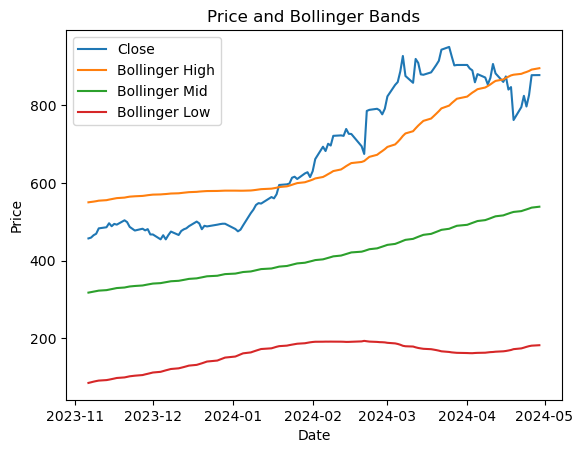

In [12]:
import matplotlib.pyplot as plt

x = 120

plt.plot(stock.index[-x:], stock.Close[-x:], label="Close")  # Plot line 1 with label
plt.plot(stock.index[-x:], stock['Bollinger High'][-x:], label="Bollinger High")  # Plot line 2 with label
plt.plot(stock.index[-x:], stock['Bollinger Mid'][-x:], label="Bollinger Mid")  # Plot line 3 with label
plt.plot(stock.index[-x:], stock['Bollinger Low'][-x:], label="Bollinger Low")  # Plot line 4 with label (added)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price and Bollinger Bands")

# Add legend
plt.legend()

# Display the plot
plt.show()

In [13]:
model = HistGradientBoostingClassifier(random_state=1)

train = stock.iloc[:-100]
test = stock.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"] + new_predictors
try:
    model.fit(train[predictors], train["Target"])
except ValueError:
    print("There is not enough historical data for this stock to fit the model, try another stock")

In [14]:
try:
    predictions = backtest(stock, model, predictors, start = 2500, step = 250)
except ValueError:
    try:
        predictions = predict_recent(test, predictors, model)
    except ValueError:
        print("There is not enough historical data for this stock to fit the model, try another stock")

In [15]:
try:
    print(predictions["Predictions"].value_counts())
except NameError:
    print("There is not enough historical data for this stock to fit the model, try another stock")

Predictions
1.0    1447
0.0    1172
Name: count, dtype: int64


In [16]:
try:
    print(precision_score(predictions["Target"], predictions["Predictions"]))
except NameError:
    print("There is not enough historical data for this stock to fit the model, try another stock")

0.7753973738769868


In [17]:
try:
    print(predictions["Target"].value_counts() / predictions.shape[0])
except NameError:
    print("There is not enough historical data for this stock to fit the model, try another stock")

Target
1    0.592211
0    0.407789
Name: count, dtype: float64


In [18]:
try:
    recent_preds = predict_recent(test, predictors, model)
    print(recent_preds.tail(10).to_string(index=True, justify='right'))
except (NameError, ValueError):
    print("There is not enough historical data for this stock to fit the model, try another stock")

                           Target  Predictions
Date                                          
2024-04-16 00:00:00-04:00       0          0.0
2024-04-17 00:00:00-04:00       0          0.0
2024-04-18 00:00:00-04:00       0          0.0
2024-04-19 00:00:00-04:00       1          0.0
2024-04-22 00:00:00-04:00       1          0.0
2024-04-23 00:00:00-04:00       0          0.0
2024-04-24 00:00:00-04:00       0          0.0
2024-04-25 00:00:00-04:00       0          0.0
2024-04-26 00:00:00-04:00       0          0.0
2024-04-29 00:00:00-04:00       0          0.0


In [19]:
try:
    if predictions.Predictions[-1] == 1:
        print("The model's most recent prediction is that", symbol, "will increase from the current close in the next", shift, "trading day(s).")
    else:
        print("The model's most recent prediction is not at least", confidence*100, "% confident that", symbol, "will increase in the next", shift, "trading day(s).")

    flag = False
    for pred in predictions.Predictions[-shift:]:
        if pred == 1:
            flag = True
            break

    if flag:
        print("\nIn the last", shift, "trading day(s), the model HAS predicted an increase in the price of", symbol, "with a confidence of at least", confidence*100, "%")
    else:
        print("\nIn the last", shift, "trading day(s), the model HAS NOT predicted an increase in the price of", symbol, "with a confidence of at least", confidence*100, "%")
except NameError:
    print("There is not enough historical data for this stock to fit the model, try another stock")

The model's most recent prediction is not at least 50.0 % confident that NVDA will increase in the next 5 trading day(s).

In the last 5 trading day(s), the model HAS NOT predicted an increase in the price of NVDA with a confidence of at least 50.0 %


In [20]:
try:
    print("Insider Transactions:\n", yf.Ticker(symbol).insider_transactions.head(10).to_string(index=False, justify='right'))
    print("\n\nRecommendation Summary:\n", yf.Ticker(symbol).recommendations_summary.to_string(index=False, justify='right'))
except Exception as e:
    print("Stock not compatible with insider transaction function")

Insider Transactions:
  Shares    Value URL                                        Text               Insider                Position Transaction Start Date Ownership
   1667        0     Stock Award(Grant) at price 0.00 per share. ROBERTSON DONALD F JR                 Officer             2024-04-08         D
  22700 19975240        Sale at price 877.00 - 882.36 per share.        STEVENS MARK A                Director             2024-04-05         I
   7000  6215259                 Sale at price 887.89 per share.          PERRY MARK L                Director             2024-04-02         I
  11000  9962150                 Sale at price 905.65 per share.        STEVENS MARK A                Director             2024-03-28         I
    128   120320                 Sale at price 940.00 per share.         DABIRI JOHN O                Director             2024-03-25         D
    450   410229                 Sale at price 911.62 per share. ROBERTSON DONALD F JR                 Officer   